In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib  as mpl

from argparse import Namespace as NS
from os.path import join
import yaml
import torch
from syngan.models import OjaNet, OjaRule
from syngan.post_hoc_analysis import (load_network_from_checkpoint as load,
                                      make_new_data)


## Load fits and make data

In [3]:
# Load test data
path_to_data = join("..", "..", "data", "oja_net_small")
test_data = np.load(join(path_to_data, "extra_test_data.npz"))

with open(join(path_to_data, "config.yaml"), "r") as f:
    sconf = NS(**yaml.full_load(f))

X, Y, PCs, weights = test_data["presyn_act"], test_data["postsyn_act"],\
test_data["presyn_pcs"], test_data["weights"]

gt_net = OjaNet(OjaRule(sconf.n_presyn_neur, sconf.n_postsyn_neur),
                sconf.update_rate,
                sconf.n_presyn_neur,
                sconf.n_postsyn_neur,
                sconf.timesteps,
                noise_amplitude=0.)


In [4]:
# For figure 4: Load all models
prefix = "../oja_net_small/"
path_to_fits = {"loc_mlp": prefix + "<>",
                "loc_oja_mlp": prefix + "<>",
                "mlp": prefix + "<>",
                "agg_mlp": prefix + "<>"
               }


generators = {k: load(path,
                      "oja_net_small",
                      path_to_sim_conf="../../data/oja_net_small/",
                      path_to_fit_conf="../tasks/oja_net_small/")
             for k, path in path_to_fits.items()
             }
generators["gt"] = gt_net


In [5]:
# Make new data
test_wts = {}
test_outputs = {}
test_score = {}

torch.manual_seed(786)
random_wts = 1e-1 * torch.abs(torch.randn(len(X), 1, 3, 1))
for k, network in generators.items():
    wt, y, score = make_new_data(net="OjaNet",
                                 rule=network.update_rule,
                                 presyn_act=X,
                                 wt_init_seed=786,
                                 init_weights=random_wts,
                                 return_score=True,
                                 score_funcn="pc_norm",
                                 PCs=PCs)
    test_wts[k] = wt
    test_outputs[k] = y
    test_score[k] = score


## Set figure properties

In [6]:
# Set general properties for figure
labels = {"gt": "Oja's Rule",
          "loc_mlp": "Local MLP",
          "loc_oja_mlp": "Oja + Local MLP",
          "mlp": "Global MLP",
          "agg_mlp": "Semi-global MLP"}
colors = {"gt": "k",
          "loc_mlp": "tab:blue",
          "loc_oja_mlp": "tab:purple",
          "agg_mlp": "tab:green",
          "mlp": "xkcd:goldenrod"}
linewidths = {"gt": 4,
              "loc_mlp": 4,
              "loc_oja_mlp": 4,
              "agg_mlp": 4,
              "mlp": 4}

# Pick random set of datasets for plotting
panel_test_dataset=69
timebins = [9, 49, 199]
keys = ["loc_mlp", "loc_oja_mlp", "agg_mlp",
        "mlp"]


## Make figure

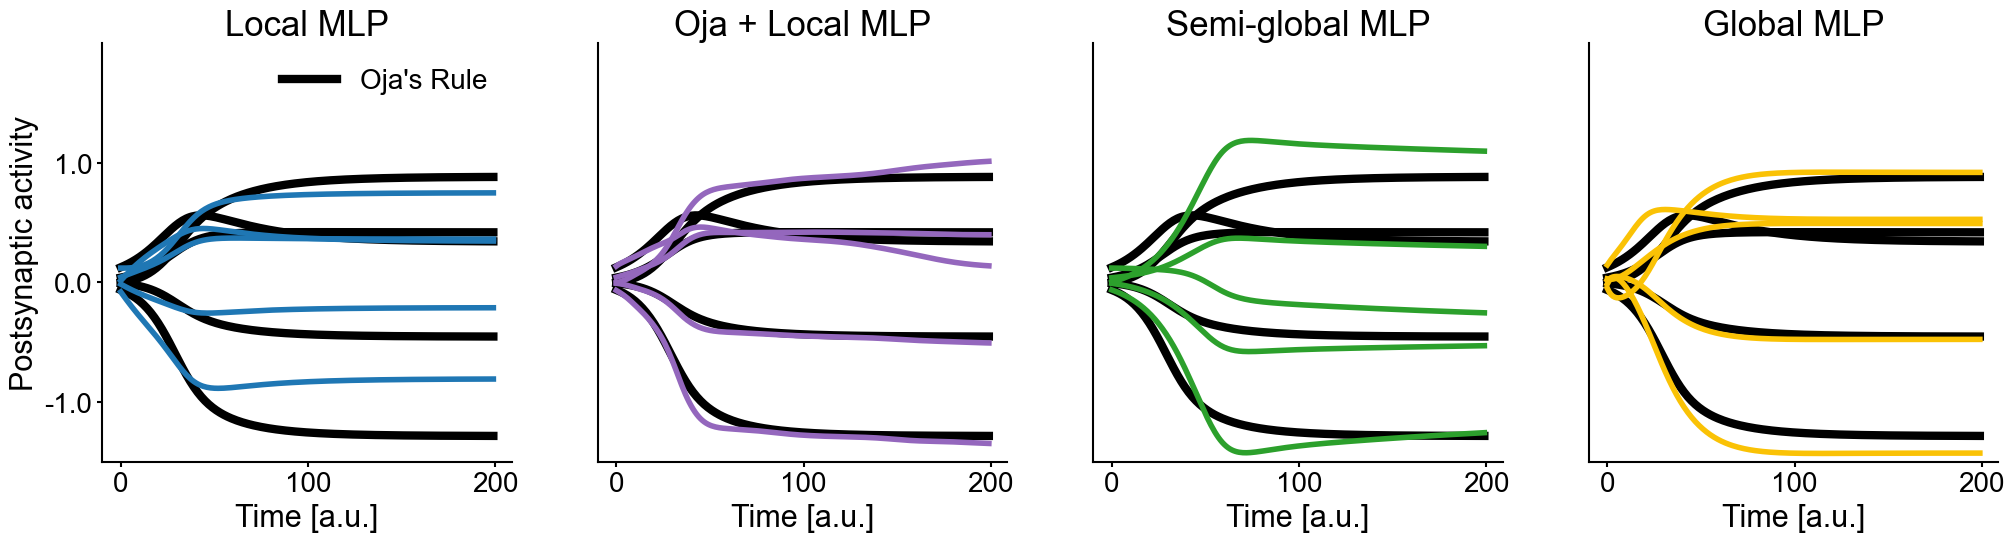

In [13]:
with mpl.rc_context(fname="./matplotlibrc"):
    fig, axes = plt.subplots(1, 4, figsize=(20, 5.))
    fig.patch.set_facecolor('white')
    fig.subplots_adjust(wspace=.3, hspace=.2)
    fig.tight_layout()

    for i, (ax, key) in enumerate(zip(axes, ["loc_mlp", "loc_oja_mlp", "agg_mlp", "mlp"])):

        ax.set_title(labels[key], fontsize=25)
        ax.tick_params(labelsize=20)

        ax.set_xlabel("Time [a.u.]", fontsize=22)

        ax.set_ylim(-1.5, 2)
        ax.set_yticks([ -1., 0., 1.])
        ax.set_yticklabels(labels=[-1., 0., 1.])

        if i == 0:
            ax.set_ylabel("Postsynaptic activity", fontsize=22)
        else:
            ax.set_yticks([])

        ax.plot(test_outputs["gt"][panel_test_dataset, 5:10].squeeze().T,
                         lw=6.,
                         color=colors["gt"])

        ax.plot(test_outputs[key][panel_test_dataset, 5:10].squeeze().T,
                     lw=4,
                     color=colors[key])
        if i==0:
            ax.plot([], [], lw=6.,
                         color=colors["gt"],
                        label=labels["gt"])
            ax.legend(fontsize=20)
    fig.savefig("supp_fig_2.jpg")
